# Step 1: Data Loading and Initial Inspection

In [1]:
import pandas as pd

df = pd.read_csv('../data/Copy of BrentOilPrices.csv')

print(df.head())

print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

print(df.describe())

        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None

Missing Values:
 Date     0
Price    0
dtype: int64
             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


# Step 2: Data Cleaning and Preprocessing

In [2]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')

missing_dates = df['Date'].isna().sum()
if missing_dates > 0:
    print(f"There are {missing_dates} dates that couldn't be converted.")
    print("Inspecting rows with conversion errors:")
    print(df[df['Date'].isna()])

df.set_index('Date', inplace=True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None


In [3]:
df.to_csv('../data/cleaned_data.csv')

In [4]:
df_cleaned = pd.read_csv('../data/cleaned_data.csv')

# Step 3: Exploratory Data Analysis (EDA)

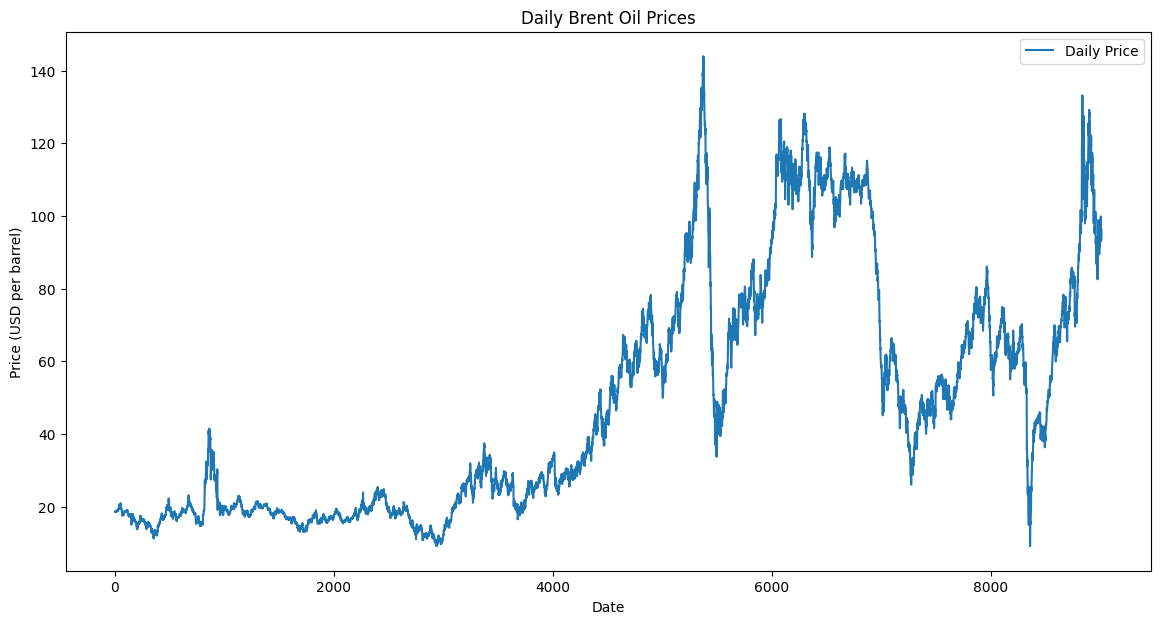

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['Price'], label='Daily Price')
plt.title('Daily Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

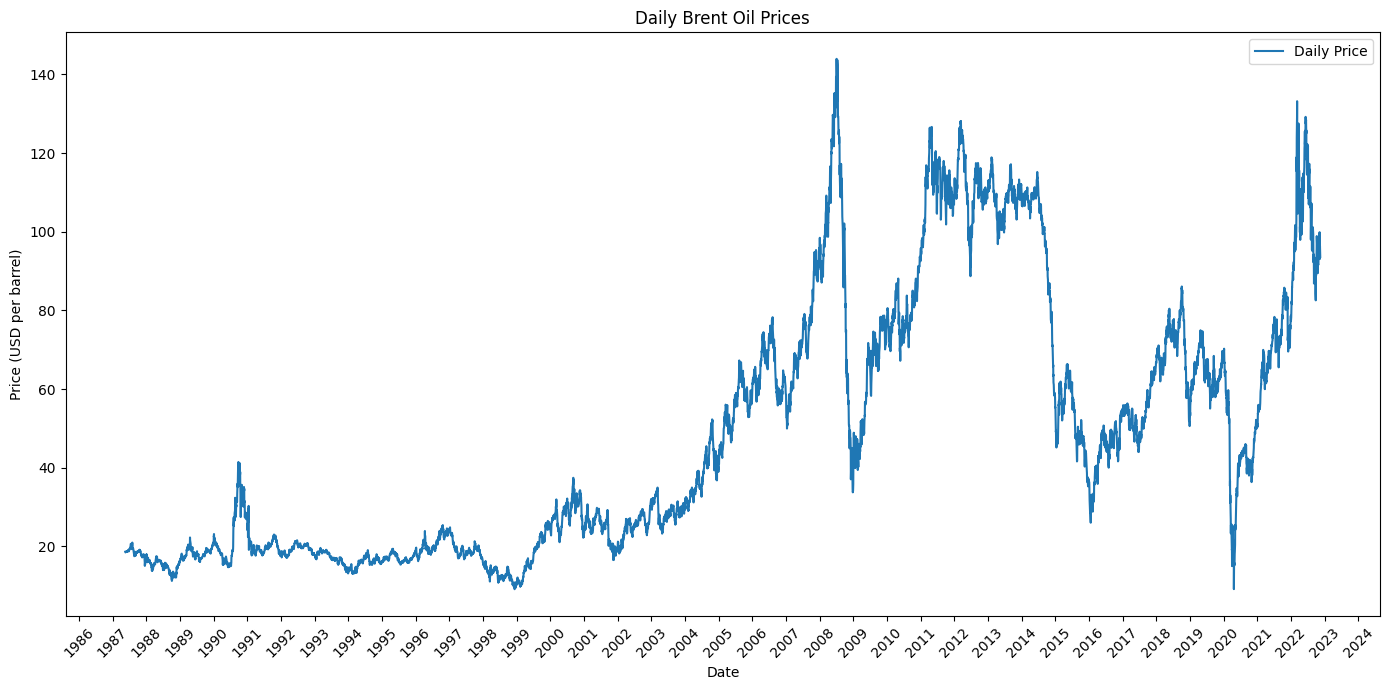

In [6]:
import matplotlib.dates as mdates

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['Price'], label='Daily Price')
plt.title('Daily Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.xticks(rotation=45) 
plt.tight_layout()      
plt.show()

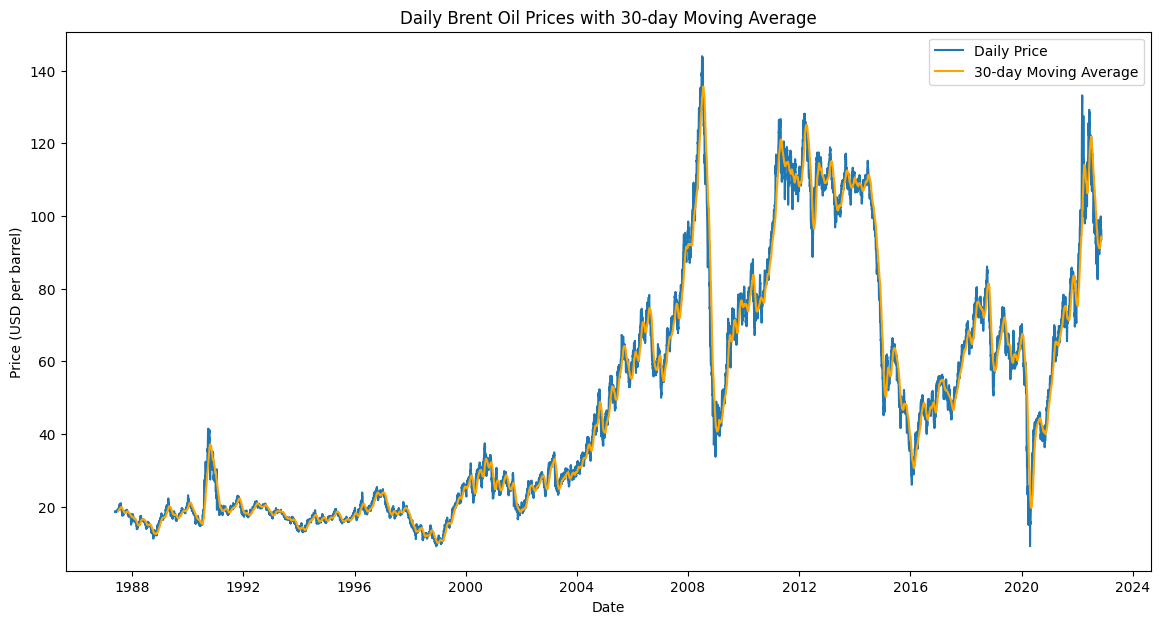

In [7]:
df_cleaned['30-day MA'] = df_cleaned['Price'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['Price'], label='Daily Price')
plt.plot(df_cleaned['30-day MA'], label='30-day Moving Average', color='orange')
plt.title('Daily Brent Oil Prices with 30-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

# Sub-Step 3.2: Time-Series Decomposition and Stationarity Tests

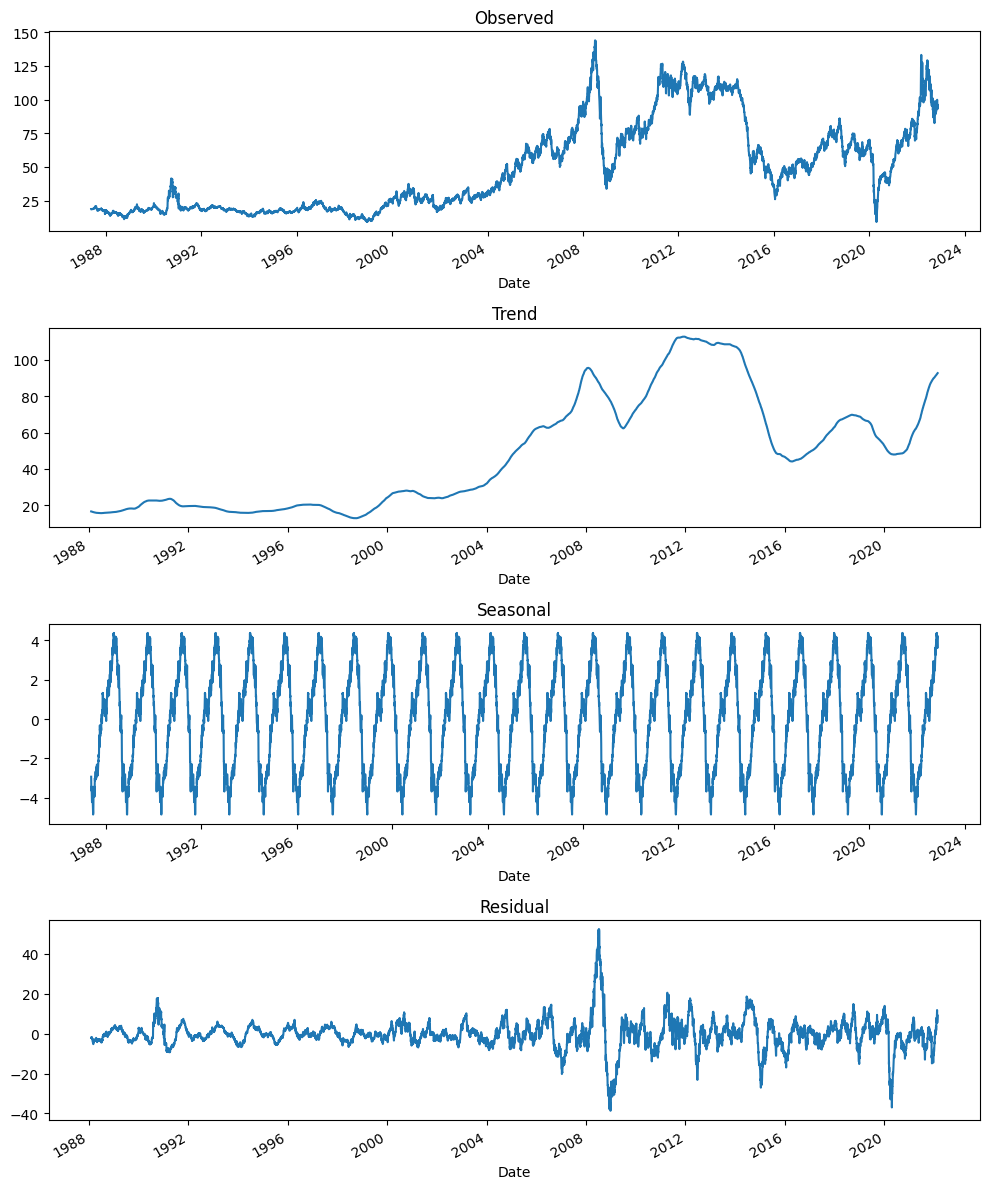

ADF Statistic: -1.993856011392467
p-value: 0.2892735048934032
Critical Values: {'1%': np.float64(-3.4310783342658615), '5%': np.float64(-2.861861876398633), '10%': np.float64(-2.566941329781918)}


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

decomposition = seasonal_decompose(df_cleaned['Price'], model='additive', period=365)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

adf_test = adfuller(df_cleaned['Price'].dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Step 4: Change Point Analysis

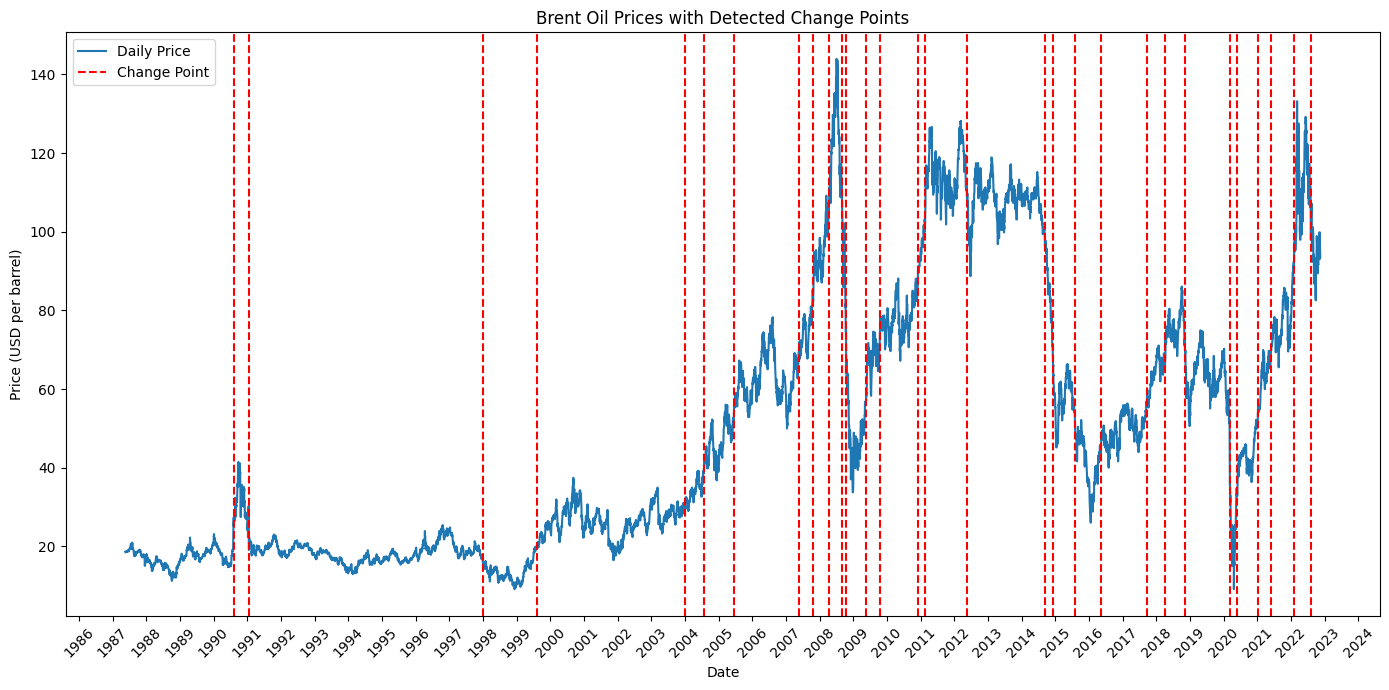

In [13]:
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'Price' column to a numpy array for the algorithm
price_data = df['Price'].values

# Perform change point detection using the PELT algorithm
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_data)
change_points = algo.predict(pen=10)

# Filter change points to ensure they are within the bounds of the dataframe index
change_points = [cp for cp in change_points if cp < len(df)]

# Plot the data with detected change points
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Daily Price')
for i, cp in enumerate(change_points):
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if i == 0 else "")
plt.title('Brent Oil Prices with Detected Change Points')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()

# Set x-axis to show ticks every year with only the year format
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)  # Rotate for readability
plt.tight_layout()       # Adjust layout to fit rotated labels
plt.show()